In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms #transforms est un module qui permet de faire des tranformations sur les images
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
"""Petite Intro à Torch"""
A = torch.rand(2, 2) #Matrice 2*2 aléatoire
x = torch.zeros(5, 3, dtype=torch.long) #Matrice 5*3 rempie de 0. dtype indique le type des coefficients
print(str(x)+"\n")                               #Ici les coeffs sont de type long

x = torch.tensor([5.5, 3])#construit un tensor à patir des donnés
print(str(x)+"\n")

x = x.new_ones(5, 3, dtype=torch.double)      # les méthodes de la forme "new_*" permettent de recréer un tensor 
print(x)                                    #à partir d'un d'un autre

x = torch.randn_like(x, dtype=torch.float)    #Crée un tensor de nombres aléat à partir de la structure de x
print("\n"+str(x)+"\n")  

    
print(str(x.size())+"\n") #torch.Size est en faite un tuple. Il supporte donc toutes les opérations de tuple


"""Redimensionner des tensors aves view()"""
x = torch.randn(4, 4)
y = x.view(16) 
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

"""convertir un tensor à un élément en un scalaire python"""
x = torch.randn(1)
print("\n"+str(x))
print(x.item())
print("\n")


"""Pour executer des instructions sur GPU, on utilise CUDA."""
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available(): #On vérifie que nôtre système supporte CUDA 
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!



tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

tensor([5.5000, 3.0000])

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

tensor([[ 0.7340,  0.9264,  0.3142],
        [-0.2020, -0.6692, -0.3600],
        [-1.3686, -0.3528, -0.8268],
        [-0.3036, -0.8676, -1.1395],
        [ 1.5883, -0.3648, -1.9789]])

torch.Size([5, 3])

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])

tensor([0.4602])
0.46022656559944153




In [4]:
plt.ion()   # interactive mode: # On active le mode interactif.
# Cela permet de voir notre graph
# en popup et de le modifier
# en temps réel.

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([ #compose permet de composer plusieurs transformations ensemble
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), #Transforme une PIL image en un tensor de dim ( channel, height, width)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalise les chanels. Le premier 
                            # argument est la moyenne (mean) et le deuxième est l'ecart type(std). La dimenssion des 2 listes
                            # correspond au nombre de channels de l'image. 
                            #La fonction s'applique à un tensor t1 et renvoie un tensor t2 tel que
                            # tel que t2(channel)=(t1(channel) - mean(channel)) / std(channel)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Ces valeures de normalisation 
                                                                        #sont imposées par le module 
                                                                        #torchvision.models que l'on va
                                                                        #utiliser pas la suite. 
                                                                        
    ]),
}
data_transforms['train']

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [5]:
data_dir = 'hymenoptera_data' #Dossier dans lequel sont les données


"""Dictionnaire contenant les datasets. Le deuxième argument de ImageFolder est la fonction/tranformation à 
appliquer aux images. 

Définition de la fonction: https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=torchvision%20dataset"""
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), #chemin du dossier où se trouve le dossier x 
                                          data_transforms[x]) for x in ['train', 'val']} 

"""La fonction DataLoader charge les images à partir de image_dataset. 
-Il répartis les données en lot (batch) de taille batch_size. 
-shuffle=true signifie que les images seront remélangées entre elles à chaque itération (epoch)
-num_workers est le nombre de sous-processus que l'on utilise pour charger les données

Plus d'info sur DataLoader: https://pytorch.org/docs/stable/data.html"""
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}# Nombre de données dans chaqun des deux dossiers



class_names = image_datasets['train'].classes
print("class_names: "+str(class_names))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


class_names: ['feu_rouge', 'interdit']
cpu


In [33]:
"""Fonction pour afficher une image passée sous forme de tensor Torch."""
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))#Transforme le tensor en ndarray (tableau numpy) avec la fonction
                                        #numpy(). Puis il transforme le tableau de manière à ce que:
                                        #La hauteur de l'image soie placée en premier, la largeure en deuxième
                                        #Et les caneaux en troisième
                                        # En tenssor Torch:(cannaux, hauteur, longueur) -> En  ndarray numpy:
                                        # (hauteur, longueur, cannaux)
                        
    """On effectue les opérations de normalisation qu'on avait fait avec la fonction transform.Normalize()"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1) # Réstreint les valeures de inp entre 0 et 1: Les val<0 deviennent 0 tandis que
                            #Les vals > 1 deviennent 1.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs: 
tensor([[[[-0.5767, -0.6281, -0.7137,  ..., -0.7308, -1.0390, -0.6109],
          [-0.4397, -0.4568, -0.5082,  ..., -0.6965, -0.8164, -0.6794],
          [-0.3541, -0.3712, -0.4397,  ..., -0.9363, -0.8678, -0.8164],
          ...,
          [ 0.2796,  0.2967,  0.2967,  ..., -0.2856,  0.2624,  0.6392],
          [ 0.2967,  0.2967,  0.2967,  ..., -0.0287,  0.7248,  0.7248],
          [ 0.3309,  0.3138,  0.3309,  ...,  0.3481,  0.5536,  0.5193]],

         [[-0.6001, -0.6527, -0.7402,  ..., -0.7052, -0.9678, -0.4601],
          [-0.4426, -0.4776, -0.5301,  ..., -0.7752, -0.8277, -0.5826],
          [-0.3550, -0.3901, -0.4426,  ..., -1.0203, -0.9328, -0.8102],
          ...,
          [ 0.2402,  0.2577,  0.2577,  ..., -0.3725,  0.1702,  0.5728],
          [ 0.2577,  0.2577,  0.2577,  ..., -0.1450,  0.6078,  0.6604],
          [ 0.2927,  0.2752,  0.2927,  ...,  0.2577,  0.4678,  0.4503]],

         [[-0.6715, -0.6890, -0.7064,  ..., -0.5670, -0.8284, -0.3404],
          [-0.4798, -

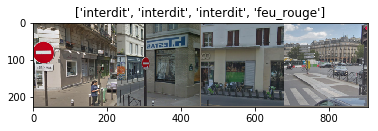

In [32]:
# Get a batch of training data
"""#iter() est une fonction qui renvoie un itérateur sur l'objet itérable(liste, dictionnaire...) passé en paramètre
#next() renvoie l'élément sur lequel pointe l'itérateur passé en paramètre et déplace ce dernier sur 
l'élément suivant. 
Plus d'info sur: https://anandology.com/python-practice-book/iterators.html"""
inputs, classes = next(iter(dataloaders['train']))
print("inputs: \n"+str(inputs)) #input est un tensor codant pour un batch(lot) de 4 images. En effet, les éléments au sein de..;
            # dataloaders['train'] sont des batches de 4 images.
print("\n\nClasses:\n"+str(classes))# classes est un tensor à une dim contenant les classes respéctives des 4 images de inputs.
            #Comme nous n'avons que 2 dossiers('feu_rouge' et 'interdit'), nous n'avons que 2 classes codées
            #par 0 et 1.

# Make a grid from batch. Fais une grille d'images à partir du Tensor passé en paramètre
#Plus d'info: https://pytorch.org/docs/stable/torchvision/utils.html?highlight=torchvision%20utils%20make_grid#torchvision.utils.make_grid
out = torchvision.utils.make_grid(inputs)#Il regroupe les 4 images en une seule de dimenssions [3, 228, 906]
print(out.size())
imshow(out, title=[class_names[x] for x in classes]) #Affiche les images

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                model.train(mode=was_training)
#model_ft = models.resnet18(pretrained=True) 
#num_ftrs = model_ft.fc.in_features

In [ ]:
"""Renvoie un réseau de neuronnes de type ResNet-18 pré-entrainé à partir de ImageNet.
Plus d'info à: https://pytorch.org/docs/stable/torchvision/models.html"""
model_ft = models.resnet18(pretrained=True) 


num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)